In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# Define a simple MLP model for regression with 5 hidden layers
class MLPRegression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [ ]:
# Define a simple MLP model for regression with 5 hidden layers
class adaptiveMLPRegression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptiveMLPRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression
        
    def forward(self, x, y, gamma_beta_dict):
        out = self.fc1(x)
        out = out * gamma_beta_dict['gamma1'] + gamma_beta_dict['beta1']
        out = self.relu(out)

        out = self.fc2(out)
        out = out * gamma_beta_dict['gamma2'] + gamma_beta_dict['beta2']
        out = self.relu(out)

        out = self.fc3(out)
        out = out * gamma_beta_dict['gamma3'] + gamma_beta_dict['beta3']
        out = self.relu(out)

        out = self.fc4(out)
        out = out * gamma_beta_dict['gamma4'] + gamma_beta_dict['beta4']
        out = self.relu(out)

        out = self.fc5(out)
        
        return out

In [ ]:
def getEmbeddings(X, y):
    embeding = torch.concat(X, y, dim=0).flatten()
    assert embeding.shape == 20
    return embeding

In [ ]:
class adaptationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, 2)  # Output layer with one node for regression
        
    def forward(self, embeddings):
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [2]:
def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    return sine_params[i][0] * torch.sin(sine_params[i][1] * X + sine_params[i][2]) + sine_params[i][3] + torch.randn(X.shape) * 0.1

In [10]:
#               [A, w, phi, B]
sine_params = [ [1, 1, 0, 0],           # 0
                [2, 1, 0, 0],           # 1
                [1, 2, 0, 0],           # 2
                [0.9, 1.5, 0.3, 0.5],   # 3
                [1, 1, 2, 0],         # 4
                [4, 0.6, 0.9, -2],      # 5
                [1.7, 4, 0.1, 0],       # 6
                [3, 2, 2.19, 0.1],      # 7
                [2, 1.5, 0, 0.5],       # 8
                [2.5, 3, 3, 2],         # 9
                [1.2, 1, 0, 0.8]]       # 10

sine_params = torch.tensor(sine_params)

# Generate synthetic data for regression
torch.manual_seed(0)

dataset = [None] * 11  # List of datasets for each function

for i in range(11):
    upper_bound = 2 * torch.pi / sine_params[i][1]
    X = torch.linspace(0, upper_bound, 100)
    y = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y

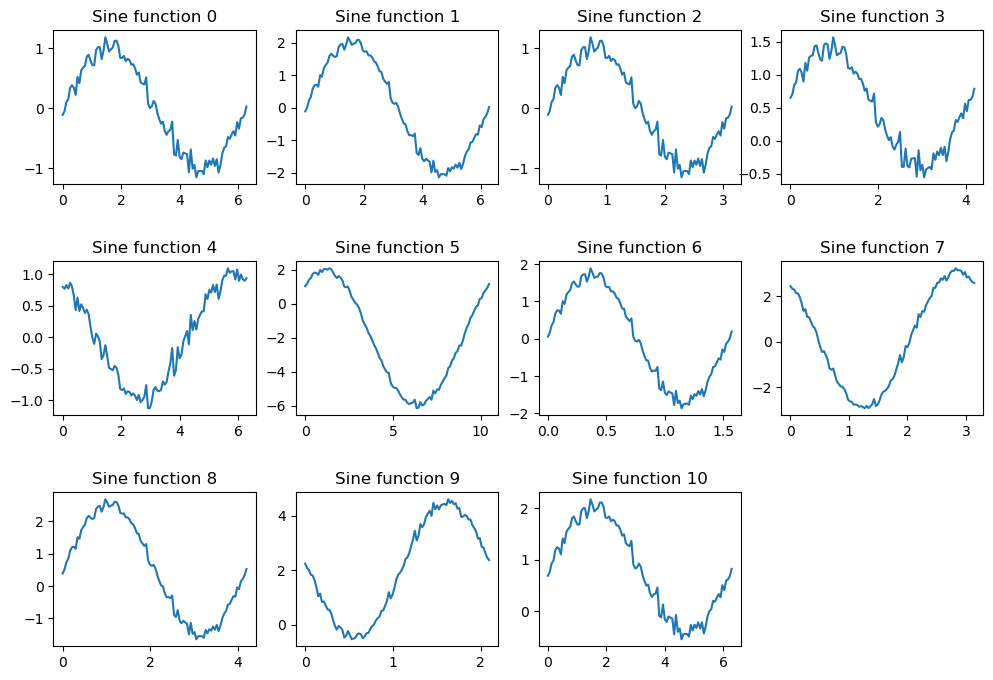

In [11]:
# plot 11 sine functions and adjust margins
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

for i in range(11):
    plt.subplot(3, 4, i+1)
    plt.plot(dataset[i][:, 0], dataset[i][:, 1])
    plt.title('Sine function {}'.format(i))

In [85]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, hidden_size = 64):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out

In [86]:
# class FiLM(nn.Module):
#     def __init__(self, input_size=3, hidden_size = 64):    # input_size = 3 corresponding to (x, y, encoder_output)
#         super(FiLM, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 2)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out

In [101]:
def get_sine(A, B, w, phi, x):
    torch.manual_seed(0)
    return A * torch.sin(w * x + phi) + B + torch.randn(x.shape) * 0.1

In [110]:
# Hyperparameters
input_size = 1  # One input feature
hidden_size = 128  # Number of neurons in each hidden layer
learning_rate = 0.01
num_epochs = 5000

# Generate synthetic data for regression
torch.manual_seed(0)
A = 2.0
B = 1.0
w = 2.0
phi = 0.1
upper_bound = 2 * torch.pi / w
X = torch.linspace(0, upper_bound, 100).reshape(100, input_size)
y = get_sine(A, B, w, phi, X)  # Sine function with noise


# Initialize the MLP regression model
# model = MLPRegression(input_size, hidden_size)
model = adaptiveMLPRegression(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    # outputs = model(X)
    outputs = model(X, y)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = model(X)
    predicted = model(X, y)

# print("Predicted values:")
# print(predicted)

# Save the trained model
torch.save(model.state_dict(), 'checkpoints/mlp_regression_model_5hiddenlayers.ckpt')
print('MLP regression model with 5 hidden layers trained and saved!')

encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1]

In [111]:
X.shape

torch.Size([100, 1])

In [112]:
y.shape

torch.Size([100, 1])

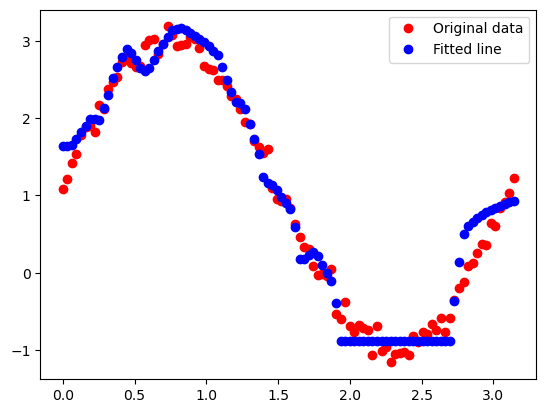

In [113]:
# plot x and y
plt.plot(X, y, 'ro', label='Original data')
plt.plot(X, predicted, 'bo', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
# class CNAPSRegression(nn.Module):
#     def __init__(self, input_size, hidden_size, num_tasks):
#         super(CNAPSRegression, self).__init__()
#         self.num_tasks = num_tasks
#         self.task_embeddings = nn.Embedding(num_tasks, hidden_size)
#         self.mlp = MLPRegression(input_size + hidden_size, hidden_size)

#     def forward(self, x, task):
#         task_embedding = self.task_embeddings(task)
#         out = torch.cat((x, task_embedding), dim=1)
#         out = self.mlp(out)
#         return out